In [41]:
ENV["LINES"] = 300
using Distributions
using StatsPlots
default(fmt=:png)

In [2]:
myquantile(dist::UnivariateDistribution, p) = quantile(dist, p)
function myquantile(dist::DiscreteUnivariateDistribution, p)
    k = quantile(dist, p)
    (!(p ≈ 1) && cdf(dist, k-1)) ≈ p ? k-1 : k 
end

mycquantile(dist::UnivariateDistribution, p) = myquantile(dist, 1 - p)

function check_myquantile(dist, k)
    b = cdf(dist, k)
    k_b = quantile(dist, b)
    kk_b = myquantile(dist, b)
    c = ccdf(dist, k)
    l_b = cquantile(dist, c)
    ll_b = mycquantile(dist, c)
    (k, (k_b, k_b == k), (kk_b, kk_b == k), (l_b, l_b == k), (ll_b, ll_b == k))
end

n, p = 10, 0.3
dist = Binomial(n, p)
[check_myquantile(dist, k) for k in 0:n]

11-element Vector{Tuple{Int64, Vararg{Tuple{Int64, Bool}, 4}}}:
 (0, (0, 1), (0, 1), (0, 1), (0, 1))
 (1, (1, 1), (1, 1), (1, 1), (1, 1))
 (2, (3, 0), (2, 1), (3, 0), (2, 1))
 (3, (3, 1), (3, 1), (3, 1), (3, 1))
 (4, (4, 1), (4, 1), (4, 1), (4, 1))
 (5, (5, 1), (5, 1), (5, 1), (5, 1))
 (6, (6, 1), (6, 1), (6, 1), (6, 1))
 (7, (7, 1), (7, 1), (7, 1), (7, 1))
 (8, (8, 1), (8, 1), (8, 1), (8, 1))
 (9, (9, 1), (9, 1), (9, 1), (9, 1))
 (10, (10, 1), (10, 1), (10, 1), (10, 1))

In [151]:
log_odds(p) = log(p) - log(1-p)
log_odds_ratio(p0, p1) = log_odds(p0) - log_odds(p1)
loglikrat(k, n, p0, p1) = k*log_odds_ratio(p0, p1) + n*(log(1-p0) - log(1-p1))
invloglikrat(llr, n, p0, p1) = (llr - n*(log(1-p0) - log(1-p1))) / log_odds_ratio(p0, p1)

function alpha_log_C(logC, n, p0, p1)
    p0 == p1 && return 0.0
    bin0 = Binomial(n, p0)
    k_α = invloglikrat(logC, n, p0, p1)
    p0 < p1 ? ccdf(bin0, ceil(k_α)-10eps()) : cdf(bin0, floor(k_α)+10eps())
end

function log_C_alpha(α, n, p0, p1)
    p0 == p1 && return 0.0
    bin0 = Binomial(n, p0)
    k_α = p0 < p1 ? mycquantile(bin0, α) + eps() : myquantile(bin0, α) - eps()
    loglikrat(k_α, n, p0, p1)
end

function test_llr_C(k, n, p0, p1, C=1/3)
    loglikrat(k, n, p0, p1) < log(C)
end

function test_llr_alpha(k, n, p0, p1, α=0.05)
    loglikrat(k, n, p0, p1) < log_C_alpha(α, n, p0, p1)
end

function test_llr_alpha2(k, n, p0, p1, α=0.05)
    p0 == p1 && return false
    bin0 = Binomial(n, p0)
    p0 < p1 ? ccdf(bin0, k-1) ≤ α : cdf(bin0, k) ≤ α
end

function test_cp(k, n, p0, p1, α=0.05)
    bin0 = Binomial(n, p0)
    min(ccdf(bin0, k-1), cdf(bin0, k)) ≤ α
end

test_cp (generic function with 2 methods)

In [149]:
n, p0, p1, C, α = 100, 0.3, 0.4, 1/3, 0.05

@show k = 67
@show llr = loglikrat(k, n, p0, p1)
@show k_ = invloglikrat(llr, n, p0, p1)
println()
@show logC = -1.3745766038776708
@show α_ = alpha_log_C(logC, n, p0, p1)
@show log_C_alpha(α_, n, p0, p1)
println()
@show α = 0.033978998268931276
@show logC_ = log_C_alpha(α, n, p0, p1)
@show alpha_log_C(logC_, n, p0, p1)
;

k = 67 = 67
llr = loglikrat(k, n, p0, p1) = -14.187726419969813
k_ = invloglikrat(llr, n, p0, p1) = 67.0

logC = -1.3745766038776708 = -1.3745766038776708
k_α = invloglikrat(logC, n, p0, p1) = 38.0
α_ = alpha_log_C(logC, n, p0, p1) = 0.033978998268931276
k_α = if p0 < p1
        mycquantile(bin0, α) + eps()
    else
        myquantile(bin0, α) - eps()
    end = 38.0
log_C_alpha(α_, n, p0, p1) = -1.3745766038776708

α = 0.033978998268931276 = 0.033978998268931276
k_α = if p0 < p1
        mycquantile(bin0, α) + eps()
    else
        myquantile(bin0, α) - eps()
    end = 38.0
logC_ = log_C_alpha(α, n, p0, p1) = -1.3745766038776708
k_α = invloglikrat(logC, n, p0, p1) = 38.0
alpha_log_C(logC_, n, p0, p1) = 0.033978998268931276


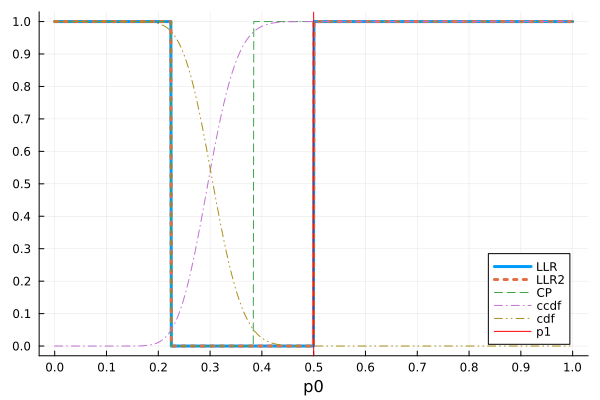

In [84]:
n, k, p1, α = 100, 30, 0.5, 0.05
ps = range(eps(), 1-eps(), 1000)
plot(ps, p0 -> test_llr_alpha(k, n, p0, p1, α); label="LLR", lw=3)
plot!(ps, p0 -> test_llr_alpha2(k, n, p0, p1, α); label="LLR2", ls=:dot, lw=3)
plot!(ps, p0 -> test_cp(k, n, p0, p1, α); label="CP", ls=:dash)
plot!(ps, p0 -> ccdf(Binomial(n, p0), k-1); label="ccdf", ls=:dashdot)
plot!(ps, p0 -> cdf(Binomial(n, p0), k); label="cdf", ls=:dashdotdot)
vline!([p1]; label="p1", c=:red)
plot!(xguide="p0")
plot!(xtick=0:0.1:1, ytick=0:0.1:1)

In [100]:
n, p0, p1, α = 1000, 0.3, 0.5, 0.05
@time mean(test_llr_alpha(rand(Binomial(n, p0)), n, p0, p1, α) for _ in 1:10^6)

  1.734623 seconds (3.02 M allocations: 61.875 MiB, 0.71% gc time, 1.23% compilation time)


0.046469

In [161]:
n, p0, p1, C = 100, 0.3, 0.5, 1/3
@time mean(test_llr_C(rand(Binomial(n, p0)), n, p0, p1, C) for _ in 1:10^6)

  0.555763 seconds (3.02 M allocations: 61.875 MiB, 2.95% gc time, 3.91% compilation time)


0.007084

In [164]:
n, p0, p1, α = 100, 0.3, 0.5, 0.00397
@time mean(test_llr_alpha(rand(Binomial(n, p0)), n, p0, p1, α) for _ in 1:10^6)

  1.902262 seconds (3.02 M allocations: 61.877 MiB, 0.89% gc time, 1.30% compilation time)


0.003939

In [162]:
[(p1, round(alpha_log_C(log(1/3), 100, 0.3, p1); sigdigits=3)) for p1 in 0.02:0.02:0.98]

49-element Vector{Tuple{Float64, Float64}}:
 (0.02, 1.56e-6)
 (0.04, 5.65e-5)
 (0.06, 0.000157)
 (0.08, 0.000969)
 (0.1, 0.00216)
 (0.12, 0.00889)
 (0.14, 0.0165)
 (0.16, 0.0288)
 (0.18, 0.0479)
 (0.2, 0.0479)
 (0.22, 0.0755)
 (0.24, 0.0755)
 (0.26, 0.0479)
 (0.28, 0.00216)
 (0.3, 0.0)
 (0.32, 0.00211)
 (0.34, 0.034)
 (0.36, 0.053)
 (0.38, 0.053)
 (0.4, 0.034)
 (0.42, 0.034)
 (0.44, 0.021)
 (0.46, 0.0125)
 (0.48, 0.00717)
 (0.5, 0.00397)
 (0.52, 0.00397)
 (0.54, 0.00211)
 (0.56, 0.00109)
 (0.58, 0.000537)
 (0.6, 0.000256)
 (0.62, 0.000117)
 (0.64, 5.19e-5)
 (0.66, 2.21e-5)
 (0.68, 9.03e-6)
 (0.7, 3.56e-6)
 (0.72, 1.35e-6)
 (0.74, 4.93e-7)
 (0.76, 5.85e-8)
 (0.78, 1.9e-8)
 (0.8, 5.93e-9)
 (0.82, 1.78e-9)
 (0.84, 1.42e-10)
 (0.86, 3.77e-11)
 (0.88, 2.35e-12)
 (0.9, 1.24e-13)
 (0.92, 5.47e-15)
 (0.94, 2.02e-16)
 (0.96, 1.01e-18)
 (0.98, 4.26e-22)

In [79]:
[(p1, round(exp(-log_C_alpha(0.05, 100, 0.3, p1)); sigdigits=4)) for p1 in 0.02:0.02:0.98]

49-element Vector{Tuple{Float64, Float64}}:
 (0.02, 1.591e-16)
 (0.04, 2.729e-10)
 (0.06, 6.053e-7)
 (0.08, 8.638e-5)
 (0.1, 0.002694)
 (0.12, 0.03162)
 (0.14, 0.1866)
 (0.16, 0.6575)
 (0.18, 1.544)
 (0.2, 2.602)
 (0.22, 3.316)
 (0.24, 3.32)
 (0.26, 2.685)
 (0.28, 1.79)
 (0.3, 1.0)
 (0.32, 1.926)
 (0.34, 3.029)
 (0.36, 3.944)
 (0.38, 4.299)
 (0.4, 3.953)
 (0.42, 3.085)
 (0.44, 2.052)
 (0.46, 1.166)
 (0.48, 0.5658)
 (0.5, 0.2346)
 (0.52, 0.08287)
 (0.54, 0.02485)
 (0.56, 0.006288)
 (0.58, 0.001334)
 (0.6, 0.0002348)
 (0.62, 3.395e-5)
 (0.64, 3.971e-6)
 (0.66, 3.696e-7)
 (0.68, 2.679e-8)
 (0.7, 1.474e-9)
 (0.72, 5.967e-11)
 (0.74, 1.708e-12)
 (0.76, 3.291e-14)
 (0.78, 4.01e-16)
 (0.8, 2.848e-18)
 (0.82, 1.0600000000000001e-20)
 (0.84, 1.784e-23)
 (0.86, 1.1070000000000001e-26)
 (0.88, 1.875e-30)
 (0.9, 5.427000000000001e-35)
 (0.92, 1.227e-40)
 (0.94, 4.984e-48)
 (0.96, 1.341e-58)
 (0.98, 6.365e-77)